**Autor:** Andrés Rueda López - Departamento de Ingeniería Industrial.

En este archivo se realiza la implementación de todos los modelos necesarios para la carga y análisis de datos.

## Importación de librerias

In [365]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import geodatasets
import geopandas as gpd
import osmnx as ox
import geopy
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import contextily as ctx
from matplotlib.lines import Line2D
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

## Carga de datos

In [366]:
test = pd.read_csv("new_test.csv")
train= pd.read_csv("new_train.csv")

# Filtrado y análisis de datos

In [367]:
train_describe = train.describe()
latex_table = train_describe.style.to_latex()

train_describe

,price,month,year,surface_total,surface_covered,rooms,bedrooms,bathrooms,lat,lon,num_habitaciones,m2,num_banos
count,3.864400e+04,38644.000000,38644.000000,7854.000000,8565.000000,20384.000000,38644.000000,28573.000000,38644.000000,38644.000000,27486.000000,9526.000000,25.00000
mean,6.545347e+08,5.665381,2020.294043,153.950216,131.932399,3.008487,3.144602,2.883771,4.691164,-74.062839,18.822200,1615.960109,13.32000
std,3.114179e+08,3.288876,0.759993,274.370273,76.616355,1.371515,1.534818,1.093248,0.037480,0.032112,747.291307,4476.789044,36.33951
min,3.000000e+08,1.000000,2019.000000,16.000000,2.000000,1.000000,0.000000,1.000000,4.576710,-74.170205,1.000000,2.000000,2.00000
25%,4.150000e+08,3.000000,2020.000000,84.000000,81.000000,2.000000,2.000000,2.000000,4.678562,-74.076479,2.000000,79.000000,2.00000
50%,5.599900e+08,5.000000,2020.000000,119.000000,108.000000,3.000000,3.000000,3.000000,4.700000,-74.050425,3.000000,117.000000,2.00000
75%,8.100000e+08,8.000000,2021.000000,185.000000,160.000000,3.000000,3.000000,3.000000,4.717737,-74.039374,3.000000,230.000000,3.00000
max,1.650000e+09,12.000000,2021.000000,17137.000000,1336.000000,11.000000,11.000000,13.000000,4.765305,-74.025706,73332.000000,95500.000000,134.00000


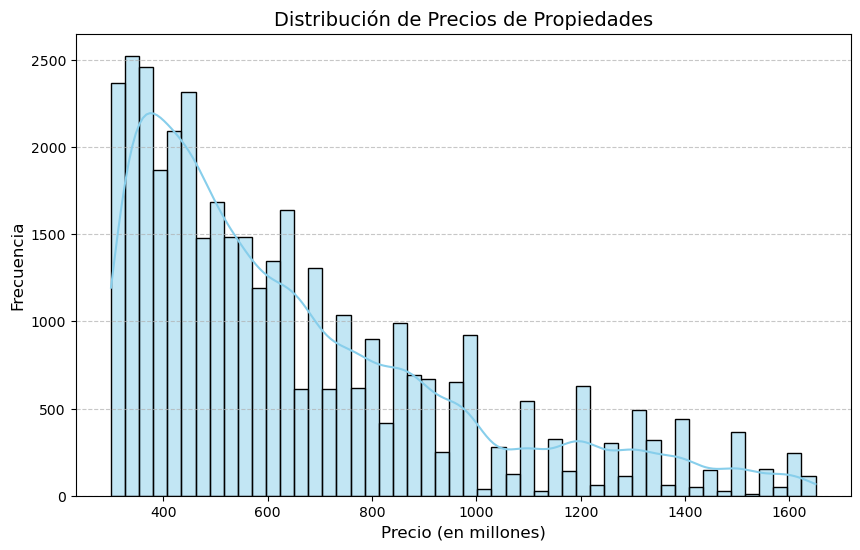

In [368]:
price = train["price"] 
def millions(x, pos):
    return f'{int(x / 1e8)}00'

# Graficar el histograma usando seaborn
plt.figure(figsize=(10, 6))
sns.histplot(price, bins=50, kde=True, color='skyblue')

# Configuración de los ejes
plt.xlabel("Precio (en millones)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.title("Distribución de Precios de Propiedades", fontsize=14)

# Aplicar el formateador al eje X
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))

# Estética adicional
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("price_dist.png")

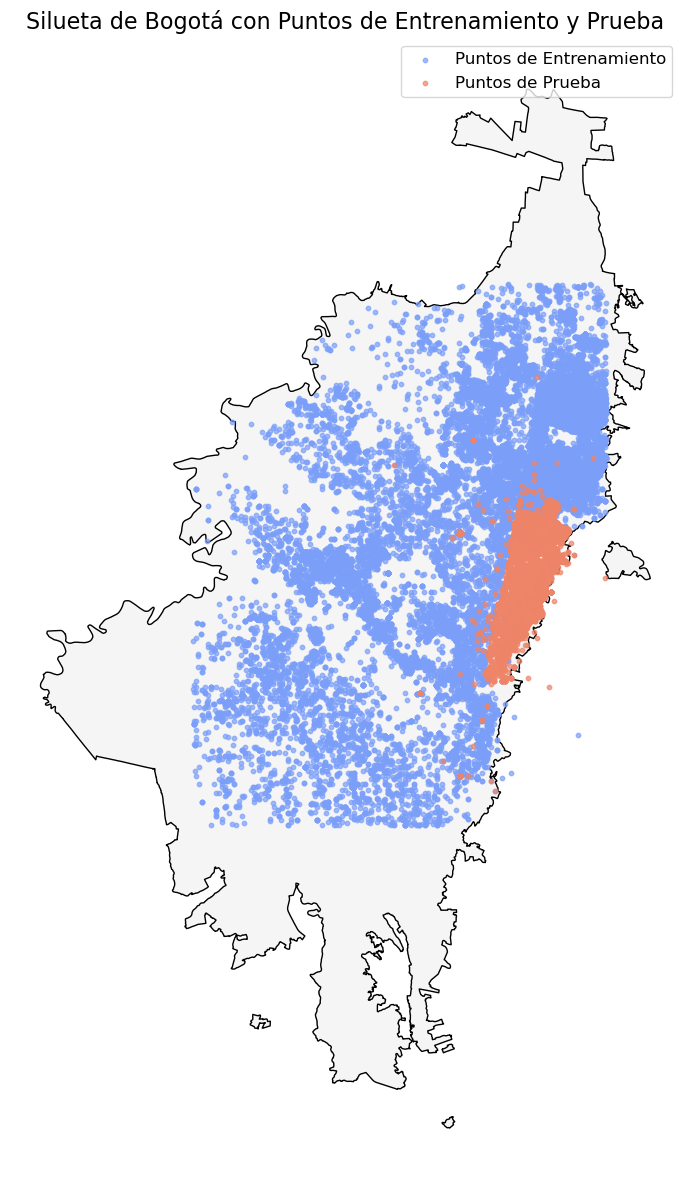

In [369]:
# Descargar la silueta de Bogotá desde OpenStreetMap
bogota = ox.geocode_to_gdf("Bogotá, Colombia")

# Crear los GeoDataFrames de puntos de entrenamiento y prueba
geometry_train = [Point(xy) for xy in zip(train['lon'], train['lat'])]
geometry_test = [Point(xy) for xy in zip(test['lon'], test['lat'])]

gdf_train = gpd.GeoDataFrame(train, geometry=geometry_train, crs="EPSG:4326")
gdf_test = gpd.GeoDataFrame(test, geometry=geometry_test, crs="EPSG:4326")

# Convertir todos los GeoDataFrames a la misma proyección
bogota = bogota.to_crs(epsg=3857)
gdf_train = gdf_train.to_crs(epsg=3857)
gdf_test = gdf_test.to_crs(epsg=3857)

# Crear el plot estilizado
plt.figure(figsize=(12, 12))
ax = plt.gca()

# Graficar la silueta de Bogotá
bogota.plot(ax=ax, color='whitesmoke', edgecolor='black', linewidth=1)

# Colores para train y test
train_color = sns.color_palette("coolwarm", as_cmap=True)(0.2)
test_color = sns.color_palette("coolwarm", as_cmap=True)(0.8)

# Graficar puntos de entrenamiento y prueba
gdf_train.plot(ax=ax, markersize=10, color=train_color, alpha=0.7, label='Puntos de Entrenamiento')
gdf_test.plot(ax=ax, markersize=10, color=test_color, alpha=0.7, label='Puntos de Prueba')

# Configuración del gráfico
plt.title("Silueta de Bogotá con Puntos de Entrenamiento y Prueba", fontsize=16)
plt.xlabel("Longitud", fontsize=12)
plt.ylabel("Latitud", fontsize=12)
plt.legend(loc="upper right", fontsize=12)
plt.grid(axis='both', linestyle='--', linewidth=0.5, alpha=0.3)
plt.axis('off')  # Ocultar los ejes para una vista más limpia

# Mostrar el gráfico
plt.tight_layout()

# Estrato

In [370]:
ruta_shp = "ManzanaEstratificacion.shp"
gdf = gpd.read_file(ruta_shp)

if 'ESTRATO' in gdf.columns:
    estratos_manzanas = gdf[['geometry', 'ESTRATO']]  # Extraer geometría y estrato
    #print(estratos_manzanas.head())
else:
    print("No se encontró una columna relacionada con el estrato.")

In [371]:
#Añadir a train y a test
geometry = [Point(xy) for xy in zip(train['lon'], train['lat'])]
geometry_t = [Point(xy) for xy in zip(test['lon'], test['lat'])]

gdf_viviendas = gpd.GeoDataFrame(train, geometry=geometry, crs="EPSG:4326")
gdf_viviendas_t = gpd.GeoDataFrame(test, geometry=geometry_t, crs="EPSG:4326")

gdf_viviendas = gdf_viviendas.to_crs(gdf.crs)
gdf_viviendas_t = gdf_viviendas.to_crs(gdf.crs)

# 4. Realizar la unión espacial (sjoin) para obtener el estrato
gdf_resultado = gpd.sjoin(gdf_viviendas, gdf[['geometry', 'ESTRATO']], how="left", op="within")
gdf_resultado_t = gpd.sjoin(gdf_viviendas_t, gdf[['geometry', 'ESTRATO']], how="left", op="within")

# 5. Añadir la columna ESTRATO 
train['ESTRATO'] = gdf_resultado['ESTRATO']
train = train.dropna(subset=['ESTRATO'])
train = train[train['ESTRATO'] != 1]

test['ESTRATO'] = gdf_resultado_t['ESTRATO']
test['ESTRATO'].fillna(int(test['ESTRATO'].mean()), inplace=True)



c:\Users\a.ruedal\AppData\Local\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\a.ruedal\AppData\Local\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


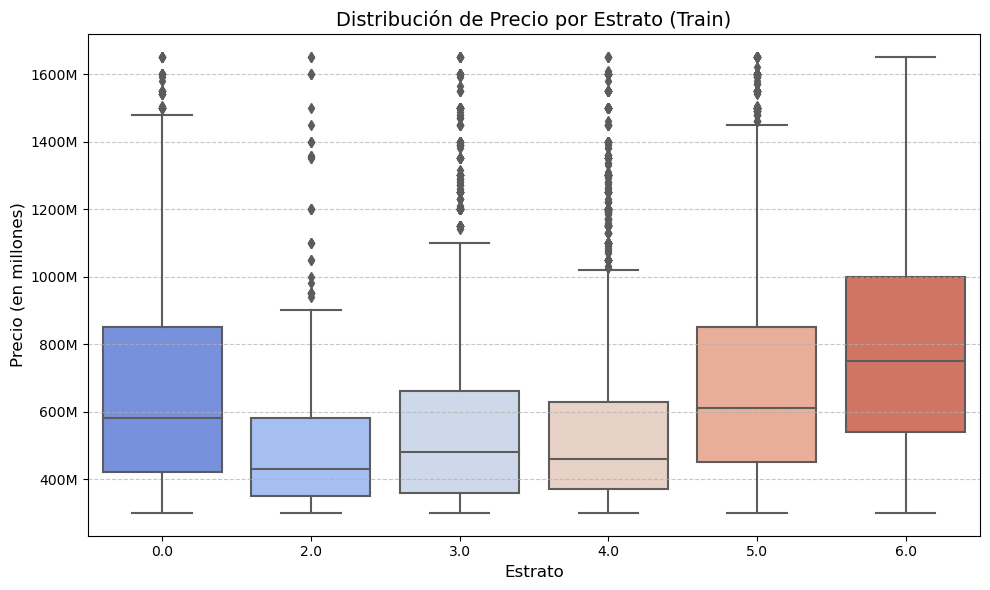

In [372]:
# Crear una función para formatear el eje Y en millones
def millions(x, pos):
    return f'{int(x / 1e6)}M'  # Mostrará precios en millones con la letra "M"

# Crear la figura y el boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=train, x='ESTRATO', y='price', palette='coolwarm')

# Configuración del formato de los ejes y del título
plt.xlabel("Estrato", fontsize=12)
plt.ylabel("Precio (en millones)", fontsize=12)
plt.title("Distribución de Precio por Estrato (Train)", fontsize=14)

# Aplicar el formateador al eje Y
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))

# Estética adicional
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Guardar la gráfica
plt.savefig("precio_por_estrato.png", dpi=300)
plt.show()


In [373]:
correlacion = train['price'].corr(train['ESTRATO'])
print("Correlación entre columna1 y columna2:", correlacion)

Correlación entre columna1 y columna2: 0.19880777236920033


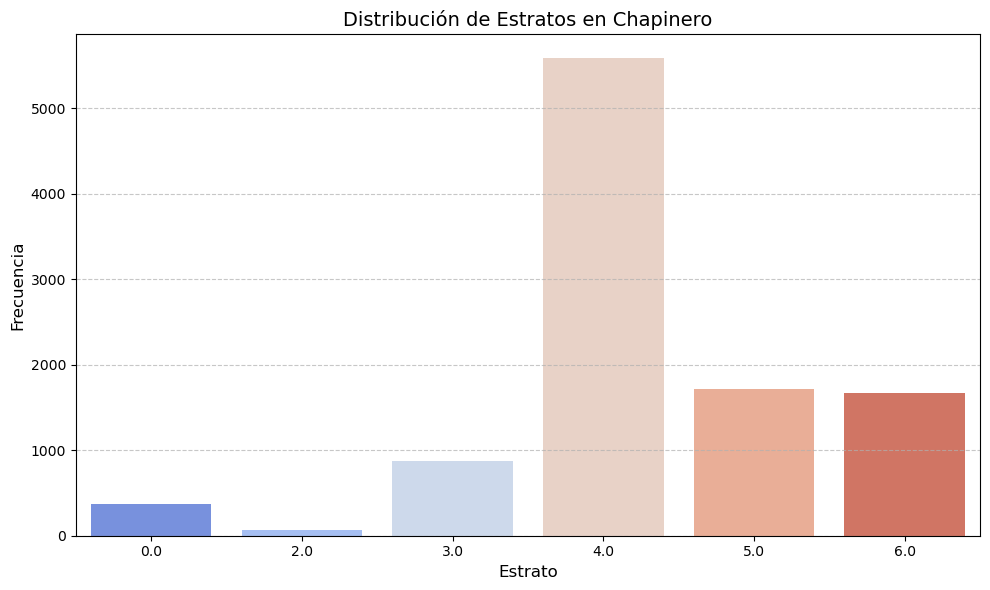

In [374]:
plt.figure(figsize=(10, 6))
sns.countplot(data=test, x='ESTRATO', palette='coolwarm')

# Configuración de los ejes y el título
plt.xlabel("Estrato", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.title("Distribución de Estratos en Chapinero", fontsize=14)

# Estética adicional
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Barrios Bogotá

In [375]:
query = "Bogotá, Colombia"
tags = {"boundary": "administrative", "admin_level": "10"}
barrios_bogota = ox.geometries_from_place(query, tags=tags)

# Mantener solo los polígonos
barrios_bogota = barrios_bogota[barrios_bogota.geometry.type == 'Polygon']
geometry = [Point(xy) for xy in zip(train['lon'], train['lat'])]
gdf_puntos = gpd.GeoDataFrame(train, geometry=geometry, crs="EPSG:4326")
gdf_puntos = gdf_puntos.to_crs(barrios_bogota.crs)
puntos_con_barrios = gpd.sjoin(gdf_puntos, barrios_bogota[['name', 'geometry']], how='inner', predicate='within')

C:\Users\a.ruedal\AppData\Local\Temp\ipykernel_19208\1479077804.py:3: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  barrios_bogota = ox.geometries_from_place(query, tags=tags)


In [376]:
train =  puntos_con_barrios[puntos_con_barrios['name'].str.contains("UPZs", case=False, na=False)]


In [377]:
localidades_incluir = [
    'UPZs Localidad Barrios Unidos', 'UPZs Localidad Teusaquillo', 'UPZs Localidad Santa Fe',
    'UPZs Localidad Usaquén', 'UPZs Localidad Suba', 'UPZs Localidad Fontibón'
]

# Filtrar el DataFrame para conservar solo las localidades especificadas
train= train[train['name'].isin(localidades_incluir)]

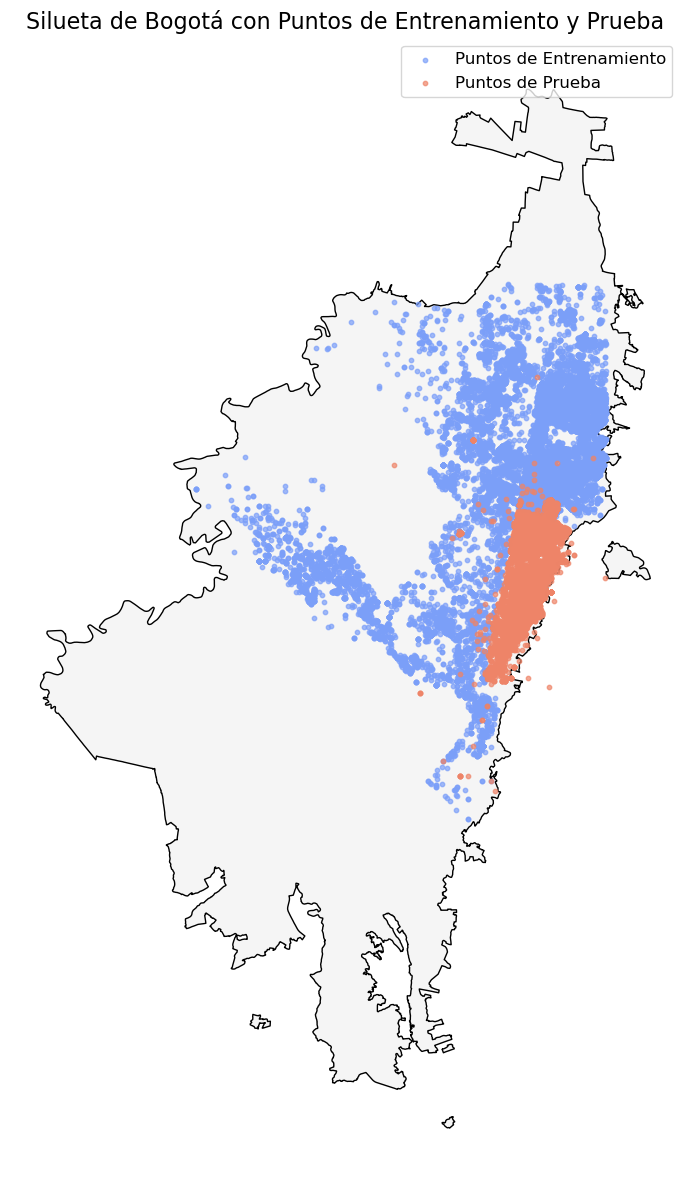

In [378]:
# Descargar la silueta de Bogotá desde OpenStreetMap
bogota = ox.geocode_to_gdf("Bogotá, Colombia")

# Crear los GeoDataFrames de puntos de entrenamiento y prueba
geometry_train = [Point(xy) for xy in zip(train['lon'], train['lat'])]
geometry_test = [Point(xy) for xy in zip(test['lon'], test['lat'])]

gdf_train = gpd.GeoDataFrame(train, geometry=geometry_train, crs="EPSG:4326")
gdf_test = gpd.GeoDataFrame(test, geometry=geometry_test, crs="EPSG:4326")

# Convertir todos los GeoDataFrames a la misma proyección
bogota = bogota.to_crs(epsg=3857)
gdf_train = gdf_train.to_crs(epsg=3857)
gdf_test = gdf_test.to_crs(epsg=3857)

# Crear el plot estilizado
plt.figure(figsize=(12, 12))
ax = plt.gca()

# Graficar la silueta de Bogotá
bogota.plot(ax=ax, color='whitesmoke', edgecolor='black', linewidth=1)

# Colores para train y test
train_color = sns.color_palette("coolwarm", as_cmap=True)(0.2)
test_color = sns.color_palette("coolwarm", as_cmap=True)(0.8)

# Graficar puntos de entrenamiento y prueba
gdf_train.plot(ax=ax, markersize=10, color=train_color, alpha=0.7, label='Puntos de Entrenamiento')
gdf_test.plot(ax=ax, markersize=10, color=test_color, alpha=0.7, label='Puntos de Prueba')

# Configuración del gráfico
plt.title("Silueta de Bogotá con Puntos de Entrenamiento y Prueba", fontsize=16)
plt.xlabel("Longitud", fontsize=12)
plt.ylabel("Latitud", fontsize=12)
plt.legend(loc="upper right", fontsize=12)
plt.grid(axis='both', linestyle='--', linewidth=0.5, alpha=0.3)
plt.axis('off')  # Ocultar los ejes para una vista más limpia

# Mostrar el gráfico
plt.tight_layout()


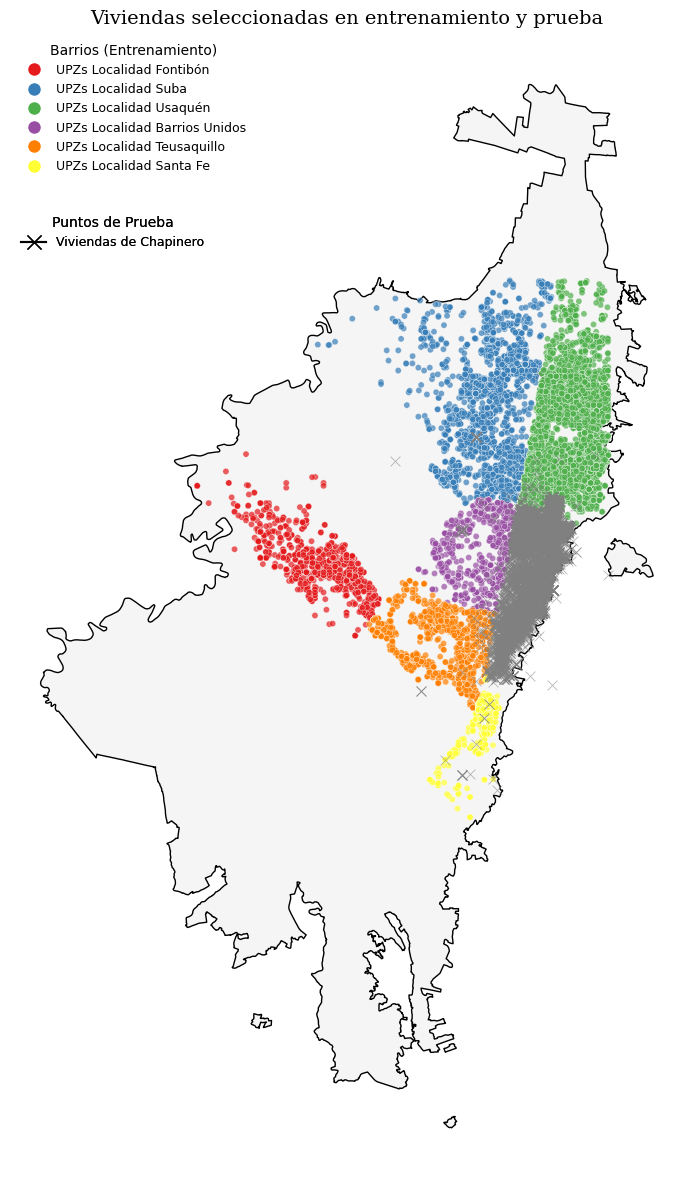

In [379]:
# Descargar la silueta de Bogotá desde OpenStreetMap
bogota = ox.geocode_to_gdf("Bogotá, Colombia")

# Crear los GeoDataFrames de puntos de entrenamiento y prueba
geometry_train = [Point(xy) for xy in zip(train['lon'], train['lat'])]
geometry_test = [Point(xy) for xy in zip(test['lon'], test['lat'])]

gdf_train = gpd.GeoDataFrame(train, geometry=geometry_train, crs="EPSG:4326")
gdf_test = gpd.GeoDataFrame(test, geometry=geometry_test, crs="EPSG:4326")

# Convertir todos los GeoDataFrames a la misma proyección
bogota = bogota.to_crs(epsg=3857)
gdf_train = gdf_train.to_crs(epsg=3857)
gdf_test = gdf_test.to_crs(epsg=3857)

# Crear el plot estilizado
plt.figure(figsize=(12, 12))
ax = plt.gca()

# Graficar la silueta de Bogotá
bogota.plot(ax=ax, color='whitesmoke', edgecolor='black', linewidth=1)

# Graficar los puntos de entrenamiento coloreados por barrio usando 'name' como hue
scatter_train = sns.scatterplot(
    x=gdf_train.geometry.x,
    y=gdf_train.geometry.y,
    hue=gdf_train['name'],
    palette='Set1',  # Paleta de colores para los barrios en train
    s=20,  # Tamaño de los puntos
    alpha=0.7,
    edgecolor="w",
    linewidth=0.3,
    ax=ax,
    legend=False  # Desactivar la leyenda automática para personalizarla
)

# Graficar los puntos de prueba con cruces como marcador
scatter_test = sns.scatterplot(
    x=gdf_test.geometry.x,
    y=gdf_test.geometry.y,
    color='grey',  # Color más suave para los puntos de prueba
    marker='x',  # Marcador de cruz para diferenciar
    s=50,  # Tamaño del marcador
    alpha=0.6,
    label='Puntos de Prueba',
    ax=ax
)

# Crear leyenda personalizada para los barrios de train
handles_train = [
    Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
    for label, color in zip(gdf_train['name'].unique(), sns.color_palette("Set1", len(gdf_train['name'].unique())))
]
train_legend = ax.legend(handles=handles_train, title="Barrios (Entrenamiento)", loc="upper left", title_fontsize='10', fontsize=9, frameon=False)

# Crear leyenda separada para los puntos de prueba
handles_test = [Line2D([0], [0], marker='x', color='black', label='Viviendas de Chapinero', markersize=10)]
test_legend = ax.legend(handles=handles_test, loc="upper left", bbox_to_anchor=(0, 0.85), title="Puntos de Prueba", title_fontsize='10', fontsize=9, frameon=False)

# Añadir ambas leyendas al gráfico
ax.add_artist(train_legend)
ax.add_artist(test_legend)

# Configuración del gráfico
plt.title("Viviendas seleccionadas en entrenamiento y prueba", fontsize=14, fontweight='normal', fontfamily='serif')
plt.xlabel("Longitud", fontsize=10)
plt.ylabel("Latitud", fontsize=10)
plt.grid(axis='both', linestyle='--', linewidth=0.5, alpha=0.3)
plt.axis('off')  # Ocultar los ejes para una vista más limpia

# Ajustar el diseño
plt.tight_layout()
plt.show()


# Variables de la vivienda

### Número de habitaciones

In [380]:
#Numero habitaciones
train['rooms'] = train['rooms'].fillna(train['num_habitaciones'])
test['rooms'] = test['rooms'].fillna(test['num_habitaciones'])

def nulos_test(df, col_name):
    if col_name in df.columns and df[col_name].dtype in ['float64', 'int64']:
        # Verificar si hay valores no nulos para evitar errores
        if df[col_name].notna().any():
            df[col_name] = df[col_name].fillna(df[col_name].median())
    return df

test = nulos_test(test, "rooms")
train = nulos_test(train, "rooms")

# Variables espaciales

### Distancia al centro de la ciudad

In [381]:
# Localización del centro de la ciudad
geolocator = Nominatim(user_agent="my_geopy_app")
centro = geolocator.geocode("Centro Internacional, Bogotá, Colombia")

def haversine(lat1, lon1, lat2, lon2):
    R = 6371 
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Fórmula Haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c  # Resultado en kilómetros

train['dist_centro'] = train.apply(
    lambda row: haversine(row['lat'], row['lon'], 4.6136147, -74.07056856752382 ), axis=1
)
test['dist_centro'] = test.apply(
    lambda row: haversine(row['lat'], row['lon'], 4.6136147, -74.07056856752382 ), axis=1
)

## Distancia colegios de más prestigio

In [382]:
colegios = [
    {"nombre": "Colegio Jordán de Sajonia", "lat": 4.6530, "lon": -74.0570},
    {"nombre": "Liceo de Cervantes El Retiro", "lat": 4.6680, "lon": -74.0480},
    {"nombre": "Colegio San Bartolomé La Merced", "lat": 4.6240, "lon": -74.0630},
    {"nombre": "Colegio Nuestra Señora del Rosario", "lat": 4.6535, "lon": -74.0595},
    {"nombre": "Colegio Agustiniano Norte", "lat": 4.7480, "lon": -74.0300},
    {"nombre": "Colegio San Tarsicio", "lat": 4.6620, "lon": -74.0590},
    {"nombre": "Colegio Nuestra Señora del Pilar", "lat": 4.6660, "lon": -74.0700},
    {"nombre": "Colegio San Francisco de Sales", "lat": 4.6660, "lon": -74.0700},
    {"nombre": "Colegio Nuestra Señora de Chiquinquirá", "lat": 4.6700, "lon": -74.0750},
    {"nombre": "Colegio San Viator", "lat": 4.6680, "lon": -74.0650},
    {"nombre": "Colegio Los Nogales", "lat": 4.6938, "lon": -74.0465},
    {"nombre": "Colegio Anglo Colombiano", "lat": 4.6660, "lon": -74.0500},
    {"nombre": "Colegio Santa Francisca Romana", "lat": 4.6960, "lon": -74.0300},
    {"nombre": "Colegio San Carlos", "lat": 4.7590, "lon": -74.0300},
    {"nombre": "Colegio Helvetia", "lat": 4.7070, "lon": -74.0500},
    {"nombre": "Gimnasio Colombo Británico", "lat": 4.7320, "lon": -74.0580},
    {"nombre": "Colegio San Patricio", "lat": 4.7325, "lon": -74.0600},
    {"nombre": "Colegio San Jorge de Inglaterra", "lat": 4.7560, "lon": -74.0600},
    {"nombre": "Colegio Abraham Lincoln", "lat": 4.7435, "lon": -74.0531},
    {"nombre": "Colegio Colombo Gales", "lat": 4.7565, "lon": -74.0650},
    {"nombre": "Colegio San José de Fontibón", "lat": 4.6780, "lon": -74.1400},
    {"nombre": "Colegio Agustiniano Ciudad Salitre", "lat": 4.6550, "lon": -74.1100},
    {"nombre": "Colegio Nuestra Señora de la Sabiduría", "lat": 4.6785, "lon": -74.1350},
    {"nombre": "Colegio San Francisco Javier", "lat": 4.6780, "lon": -74.1355},
    {"nombre": "Colegio La Felicidad", "lat": 4.6780, "lon": -74.1355}
]


cc_df = pd.DataFrame(colegios)

# Función para encontrar el centro comercial más cercano
def col_cercano(lat_v, lon_v):
    distancias = cc_df.apply(
        lambda row: geodesic((lat_v, lon_v), (row["lat"], row["lon"])).kilometers, axis=1
    )
    idx_min = distancias.idxmin()  # Índice del centro comercial más cercano
    return cc_df.loc[idx_min, "nombre"], distancias.min()

# Aplicar la función a cada vivienda
train[["col_mas_cercano", "distancia_col"]] = train.apply(
    lambda row: col_cercano(row["lat"], row["lon"]), axis=1, result_type="expand"
)

test[["col_mas_cercano", "distancia_col"]] = test.apply(
    lambda row: col_cercano(row["lat"], row["lon"]), axis=1, result_type="expand")

In [446]:
centros_empresariales = [
    {"nombre": "Zona Financiera de la Calle 72 (Avenida Chile)", "lat": 4.6585, "lon": -74.0590},
    {"nombre": "Parque de la 93", "lat": 4.6769, "lon": -74.0486},
    {"nombre": "Centro Empresarial Santa Bárbara", "lat": 4.6934, "lon": -74.0300}
]

def calcular_distancia(row, centro_lat, centro_lon):
    return geodesic((row['lat'], row['lon']), (centro_lat, centro_lon)).kilometers

# Calcular la distancia a cada centro y añadir columnas en el DataFrame
for centro in centros_empresariales:
    nombre_columna = f"distancia_a_{centro['nombre'].replace(' ', '_')}"
    train[nombre_columna] = train.apply(
        lambda row: calcular_distancia(row, centro['lat'], centro['lon']), axis=1
    )
    test[nombre_columna] = test.apply(
        lambda row: calcular_distancia(row, centro['lat'], centro['lon']), axis=1
    )


In [447]:
train.columns

Index(['property_id', 'city', 'price', 'month', 'year', 'surface_total',
       'surface_covered', 'rooms', 'bedrooms', 'bathrooms', 'property_type',
       'operation_type', 'lat', 'lon', 'title', 'description',
       'num_habitaciones', 'm2', 'num_banos', 'ESTRATO', 'geometry',
       'index_right0', 'index_right1', 'name', 'dist_centro',
       'col_mas_cercano', 'distancia_col',
       'distancia_a_Zona_Financiera_de_la_Calle_72_(Avenida_Chile)',
       'distancia_a_Parque_de_la_93',
       'distancia_a_Centro_Empresarial_Santa_Bárbara'],
      dtype='object')

In [492]:
X_tt = pd.get_dummies(train, columns=['ESTRATO'], drop_first=True)
X_t = pd.get_dummies(test, columns=['ESTRATO'], drop_first=True)

In [493]:
X_tt.columns

Index(['property_id', 'city', 'price', 'month', 'year', 'surface_total',
       'surface_covered', 'rooms', 'bedrooms', 'bathrooms', 'property_type',
       'operation_type', 'lat', 'lon', 'title', 'description',
       'num_habitaciones', 'm2', 'num_banos', 'geometry', 'index_right0',
       'index_right1', 'name', 'dist_centro', 'col_mas_cercano',
       'distancia_col',
       'distancia_a_Zona_Financiera_de_la_Calle_72_(Avenida_Chile)',
       'distancia_a_Parque_de_la_93',
       'distancia_a_Centro_Empresarial_Santa_Bárbara', 'ESTRATO_2.0',
       'ESTRATO_3.0', 'ESTRATO_4.0', 'ESTRATO_5.0', 'ESTRATO_6.0'],
      dtype='object')

# Modelos

In [494]:
y = X_t["price"]

In [495]:
X = X_t[['ESTRATO_2.0', 'ESTRATO_3.0',
       'ESTRATO_4.0', 'ESTRATO_5.0', 'ESTRATO_6.0', 'dist_centro', 'distancia_col', 'rooms', 'distancia_a_Zona_Financiera_de_la_Calle_72_(Avenida_Chile)',
       'distancia_a_Parque_de_la_93',
       'distancia_a_Centro_Empresarial_Santa_Bárbara']]
X_t = X_tt[['ESTRATO_2.0', 'ESTRATO_3.0',
       'ESTRATO_4.0', 'ESTRATO_5.0', 'ESTRATO_6.0', 'dist_centro', 'distancia_col', 'rooms', 'distancia_a_Zona_Financiera_de_la_Calle_72_(Avenida_Chile)',
       'distancia_a_Parque_de_la_93',
       'distancia_a_Centro_Empresarial_Santa_Bárbara']]

In [496]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Xt_scaled = scaler.fit_transform(X_t)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Regresión Lineal

In [453]:
# Crear el modelo base
model = LinearRegression()

# Búsqueda de las mejores características con RFE y validación cruzada usando MAE
rfecv = RFECV(estimator=model, step=1, scoring='neg_mean_absolute_error', cv=30)
rfecv.fit(X_train, y_train)

# Mostrar las mejores características seleccionadas
print(f'Mejor número de características: {rfecv.n_features_}')
print(f'Características seleccionadas: {rfecv.support_}')

# Usar las características seleccionadas para entrenar el modelo
X_train_rfe = rfecv.transform(X_train)
X_test_rfe = rfecv.transform(X_test)

# Entrenar el modelo con las mejores características
model.fit(X_train_rfe, y_train)

# Hacer predicciones y evaluar el modelo usando MAE y R²
y_pred = model.predict(X_test_rfe)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'R² Score: {r2:.4f}')


Mejor número de características: 9
Características seleccionadas: [ True  True  True False  True  True  True False  True  True  True]
Mean Absolute Error: 225924008.4743
R² Score: 0.1354


## XgBoost

In [497]:
from sklearn.model_selection import GroupKFold, GridSearchCV
# Definir el modelo de XGBoost
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definir los hiperparámetros que deseas ajustar
param_grid = {
    'n_estimators': [800],
    'max_depth': [7],
    'learning_rate': [0.2],
    'subsample': [1],
    'colsample_bytree': [1.0]
}

# Configurar validación cruzada espacial usando GroupKFold basada en los barrios
group_kfold = GroupKFold(n_splits=5)

# Configurar la búsqueda de hiperparámetros con MAE como métrica
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=group_kfold.split(X_train, y_train, groups=["name"]),  # Grupos basados en barrios
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y los mejores parámetros
best_model = grid_search.best_estimator_
print("Mejores Hiperparámetros:", grid_search.best_params_)

# Predecir sobre el conjunto de prueba
y_pred = best_model.predict(X_test)

# Evaluar el modelo con MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

ValueError: Found input variables with inconsistent numbers of samples: [8228, 8228, 1]

In [429]:
y_h = best_model.predict(Xt_scaled)

In [430]:
print(y_h)

[6.1174816e+08 5.7407898e+08 3.9371898e+08 ... 7.2582048e+08 7.3746010e+08
 4.7374797e+08]


In [413]:
#submission
submission = pd.DataFrame({
    'property_id': test['property_id'],  # Asumiendo que el dataset de prueba tiene una columna 'Id'
    'price': y_h
})

In [431]:
submission.to_csv('submission.csv', index=False)

## Suport Vector Machine

In [476]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error


pipeline = Pipeline([
    ('svr', SVR())
])

# Definir los hiperparámetros para SVR
param_grid = {
    'svr__C': [10],            # Parámetro de penalización
    'svr__epsilon': [0.2],     # Margen de error permitido
    'svr__kernel': ['poly'],   # Tipo de kernel, rbf y poly son comunes para no linealidad
    'svr__degree': [3],        # Solo se usa si kernel='poly'
    'svr__gamma': ['auto']     # Escala del kernel rbf
}

# Configurar validación cruzada con GroupKFold basada en barrios
group_kfold = GroupKFold(n_splits=5)

# Configurar GridSearchCV con validación cruzada espacial
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=group_kfold.split(X_train, y_train, groups=train["name"]),  # Grupos según la columna "name"
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y los mejores parámetros
best_model = grid_search.best_estimator_
print("Mejores Hiperparámetros:", grid_search.best_params_)

# Predecir sobre el conjunto de prueba
y_pred = best_model.predict(X_test)

# Evaluar el modelo con MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)


ValueError: Found input variables with inconsistent numbers of samples: [17688, 17688, 22110]

In [420]:
yy = best_model.predict(Xt_scaled)

In [421]:
yy

array([5.70002668e+08, 5.70002662e+08, 5.67805977e+08, ...,
       5.70002842e+08, 5.70005263e+08, 5.70002929e+08])

## Redes neuronales

In [456]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error

# Definir la arquitectura del modelo
model = Sequential([
    Dense(32, input_shape=(X_train.shape[1],)),  # Primera capa oculta con 128 neuronas
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16),  # Tercera capa oculta con 32 neuronas
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),

    Dense(8),  # Cuarta capa oculta con 16 neuronas
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='linear')  # Capa de salida para regresión
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

# Configuración de Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluar el modelo
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)


Epoch 1/100


c:\Users\a.ruedal\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\a.ruedal\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


553/553 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 665925632.0000 - val_loss: 663154304.0000
Epoch 2/100
553/553 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 662429696.0000 - val_loss: 663154304.0000
Epoch 3/100
553/553 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 666996672.0000 - val_loss: 663154240.0000
Epoch 4/100
553/553 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 665469248.0000 - val_loss: 663154240.0000
Epoch 5/100
553/553 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 661229696.0000 - val_loss: 663154176.0000
Epoch 6/100
553/553 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 661578496.0000 - val_loss: 663154176.0000
Epoch 7/100
553/553 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 663580032.0000 - val_loss: 663154176.0000
Epoch 8/100
553/553 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 665091200.0000 - val_loss: 663154048.0000
Epoch 9/100
553/553 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 666141312.0000 - val_loss: 663153984.0000
Epoch 10/100
553/553 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 661945856.0000 - val_lo